# Structural Changes in the q Model: lecture notes experiments

This notebook simulates the thought experiments discussed in Christopher D. Carroll's graduate
Macroeconomics [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Investment/qModel/):
productivity, corporate tax rate, and investment tax credit changes. For each experiment, the the figure from the lecture notes is reproduced.

For each change I display the behavior of the model in two different
contexts:
* The change takes place at $t=0$ without notice.
* The change is announced at $t=0$ but takes place at $t=5$.

In [99]:

# Preamble
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings

try:
    plt.style.use("seaborn-v0_8-whitegrid")
except (OSError, ValueError):
    plt.style.use("seaborn-whitegrid")

matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams.update({
    "axes.titlesize": 16,
    "axes.edgecolor": "#444444",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.facecolor": "#f7f7f7",
    "axes.facecolor": "#f7f7f7",
    "legend.frameon": False,
})

warnings.filterwarnings(
    "ignore",
    message=r"\s*Capital (became negative|diverged).*Holding capital constant.",
    category=RuntimeWarning,
)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module=r".*Qmod\.q_investment",
)

from copy import deepcopy
from scipy import optimize

from dolo import *
import dolo.algos.perfect_foresight as pf
import dolo.algos.value_iteration as vi

import pandas as pd

# Since the Qmod class is in other folder we need to
# change the path.
import sys
sys.path.append('../')
from Qmod import Qmod


Since the plots for every experiment have the same format, I first define functions that carry out the analysis given a path for the exogenous variables.

In [100]:

# Function definitions
def pathValue(invest,mod1,mod2,k0,t):
    """
    Computes the value of taking investment decisions [i(0),i(1),...,i(t-1)]
    starting at capital k0 and knowing that the prevailing model will switch
    from mod1 to mod2 at time t.
    """

    k = np.zeros(t+1)
    k[0] = k0
    value = 0

    for i in range(t):
        flow = mod1.flow(k[i],invest[i])
        value += flow*mod1.beta**i
        k[i+1] = k[i]*(1-mod1.delta) + invest[i]

    value += (mod1.beta**t)*mod2.value_func(k[t])
    return value

def structural_change(mod1,mod2,k0,t_change,T_sim,npoints = 300, figname = None, experiment_label=None):
    """
    Computes (optimal) capital and lambda dynamics in face of a structural change.
    """

    def describe_experiment():
        if experiment_label:
            return experiment_label

        change_bits = []
        for attr, label in [
            ("psi", "Productivity (psi)"),
            ("tau", "Corporate tax (tau)"),
            ("zeta", "Investment tax credit (zeta)"),
            ("alpha", "Capital share (alpha)"),
            ("omega", "Adjustment cost (omega)"),
            ("delta", "Depreciation (delta)"),
            ("beta", "Discount factor (beta)"),
        ]:
            old, new = getattr(mod1, attr), getattr(mod2, attr)
            if not np.isclose(old, new):
                change_bits.append(f"{label}: {old:.3g} -> {new:.3g}")

        timing = (
            "Unanticipated: takes effect at t=0"
            if t_change == 0
            else f"Announced at t=0, takes effect at t={t_change}"
        )
        if not change_bits:
            change_bits.append("Structural change")
        return " | ".join(change_bits + [timing])

    def padded_limits(arrs, pad=0.08, fallback=1.0):
        data = np.concatenate([np.ravel(np.asarray(a)) for a in arrs])
        data = data[np.isfinite(data)]
        if data.size == 0:
            return (-fallback, fallback)
        low, high = data.min(), data.max()
        span = high - low
        if span == 0:
            span = max(abs(low), fallback)
        buffer = span * pad if span > 0 else pad * fallback
        return low - buffer, high + buffer

    title_text = describe_experiment()

    if t_change > 0:
        fobj = lambda x: -1*pathValue(x,mod1,mod2,k0,t_change)
        inv = optimize.minimize(fobj,x0 = np.ones(t_change)*mod1.kss*mod2.delta,
                                options = {'disp': True},
                                tol = 1e-16).x
    else:
        inv = None

    k = np.zeros(T_sim)
    lam = np.zeros(T_sim)
    invest = np.zeros(T_sim)

    k[0] = k0
    for i in range(0,T_sim-1):
        if i < t_change:
            k[i+1] = k[i]*(1-mod1.delta) + inv[i]
            lam[i] = mod1.findLambda(k[i],k[i+1])
            invest[i] = inv[i]
        else:
            k[i+1] = mod2.k1Func(k[i])
            lam[i] = mod2.findLambda(k[i],k[i+1])
            invest[i] = k[i+1] - (1-mod2.delta)*k[i]

    lam[T_sim-1] = mod2.findLambda(k[T_sim-1],mod2.k1Func(k[T_sim-1]))
    invest[T_sim-1] = mod2.k1Func(k[T_sim-1]) - (1-mod2.delta)*k[T_sim-1]

    Pcal = np.array([1-mod1.zeta]*t_change + [1-mod2.zeta]*(T_sim-t_change))
    q = lam/Pcal

    fig, ax = plt.subplots(3, 2, figsize=(15,12), sharex='col',
                           gridspec_kw={'hspace':0.38, 'wspace':0.22})
    fig.patch.set_facecolor('#f7f7f7')

    path_color = '#2f4858'
    highlight_color = '#d62728'
    colors = ['#1f77b4','#ff7f0e']
    labels = ['Pre-change','Post-change']

    k_range = np.linspace(0.1*min(mod1.kss,mod2.kss),2*max(mod1.kss,mod2.kss),
                          npoints)
    mods = [mod1,mod2]
    lambda_loci = []
    stable_arms = []
    stable_arms_q = []

    # Plot k,lambda path (dots only)
    ax[0,0].scatter(k, lam, color=path_color, s=26, label='Transition path', zorder=3)
    ax[0,0].scatter(k[t_change],lam[t_change], color=highlight_color, s=36, zorder=5,
                    label='Change takes effect')

    for i in range(2):
        lam_locus = np.array([mods[i].lambda0locus(x) for x in k_range])
        lambda_loci.append(lam_locus)
        arm = np.array([mods[i].findLambda(k0=x, k1=mods[i].k1Func(x)) for x in k_range])
        stable_arms.append(arm)
        stable_arms_q.append(arm / mods[i].P)

        ax[0,0].plot(k_range,mods[i].P*np.ones(npoints),
                     linestyle = '--', color = colors[i],label = labels[i]+' $\dot{k}=0$')
        ax[0,0].plot(k_range,lam_locus,
                     linestyle = '--', color = colors[i], label = labels[i]+' $\dot{\lambda}=0$')
        ax[0,0].plot(k_range, arm, linestyle='-', color=colors[i], label=labels[i]+' stable arm')
        ax[0,0].plot(mods[i].kss,mods[i].P,marker = '*', markersize=12, color = colors[i])

    ax[0,0].set_xlabel('$k$')
    ax[0,0].set_ylabel('$\lambda$')
    ax[0,0].set_title('$k$ vs $\lambda$')
    ax[0,0].set_ylim(padded_limits([lam] + lambda_loci + [[mods[0].P, mods[1].P]]))
    ax[0,0].legend(fontsize=10)

    # 2nd plot: q phase diagrams (dots only)
    ax[0,1].scatter(k,q, color=path_color, s=26, label='Transition path', zorder=3)
    ax[0,1].scatter(k[t_change],q[t_change], color=highlight_color, s=36, zorder=5,
                    label='Change takes effect')

    q_loci = []
    for i in range(2):
        lam_locus = lambda_loci[i]
        q_locus = lam_locus/mods[i].P
        q_loci.append(q_locus)
        ax[0,1].plot(k_range,np.ones(npoints),
                     linestyle = '--', color = colors[i],label = labels[i]+' $\dot{k}=0$')
        ax[0,1].plot(k_range,q_locus,
                     linestyle = '--', color = colors[i], label = labels[i]+' $\dot{q}=0$')
        ax[0,1].plot(k_range, stable_arms_q[i], linestyle='-', color=colors[i], label=labels[i]+' stable arm')
        ax[0,1].plot(mods[i].kss,1,marker = '*', markersize=12, color = colors[i])

    ax[0,1].set_xlabel('$k$')
    ax[0,1].set_ylabel('$q$')
    ax[0,1].set_title('$k$ vs $q$')
    ax[0,1].set_ylim(padded_limits([q] + q_loci + [[1]]))
    ax[0,1].legend(fontsize=10)

    # 3rd plot: capital dynamics
    time = range(T_sim)
    for axis in ax[1:,:].ravel():
        axis.axvline(t_change, color=highlight_color, linestyle='--', linewidth=1,
                     alpha=0.8)

    ax[1,0].plot(time, k, color=path_color, marker='o', markersize=4, linestyle='None')
    ax[1,0].axhline(mod1.kss, color=colors[0], linestyle=':', linewidth=1.2,
                    label='Pre-change $k^*$')
    ax[1,0].axhline(mod2.kss, color=colors[1], linestyle='-.', linewidth=1.2,
                    label='Post-change $k^*$')
    ax[1,0].set_xlabel('$t$')
    ax[1,0].set_ylabel('$k_t$')
    ax[1,0].set_title('Capital dynamics')
    ax[1,0].set_ylim(padded_limits([k, [mod1.kss, mod2.kss]]))
    ax[1,0].legend(fontsize=11)

    # 4th plot: lambda dynamics
    ax[1,1].plot(time, lam, color=path_color, marker='o', markersize=4, linestyle='None')
    ax[1,1].axhline(mod1.P, color=colors[0], linestyle=':', linewidth=1.2,
                    label='Pre-change $\lambda^*$')
    ax[1,1].axhline(mod2.P, color=colors[1], linestyle='-.', linewidth=1.2,
                    label='Post-change $\lambda^*$')
    ax[1,1].set_xlabel('$t$')
    ax[1,1].set_ylabel('$\lambda_t$')
    ax[1,1].set_title('Marginal value dynamics')
    ax[1,1].set_ylim(padded_limits([lam, [mods[0].P, mods[1].P]]))
    ax[1,1].legend(fontsize=11)

    # 5th plot: investment dynamics
    ax[2,0].plot(time, invest, color=path_color, marker='o', markersize=4, linestyle='None')
    ax[2,0].axhline(0, color='#666666', linestyle=':', linewidth=1, alpha=0.7, label='$i=0$')
    ax[2,0].set_xlabel('$t$')
    ax[2,0].set_ylabel('$i_t$')
    ax[2,0].set_title('Investment dynamics')
    ax[2,0].set_ylim(padded_limits([invest, [0]]))
    ax[2,0].legend(fontsize=10)

    # 6th plot: q dynamics
    ax[2,1].plot(time, q, color=path_color, marker='o', markersize=4, linestyle='None')
    ax[2,1].axhline(1, color='#666666', linestyle=':', linewidth=1, alpha=0.7, label='$q=1$')
    ax[2,1].set_xlabel('$t$')
    ax[2,1].set_ylabel('$q_t$')
    ax[2,1].set_title('q dynamics')
    ax[2,1].set_ylim(padded_limits([q, [1]]))
    ax[2,1].legend(fontsize=10)

    for axis in ax.flat:
        axis.grid(True, alpha=0.25)

    fig.suptitle(title_text, y=0.965, fontsize=18)
    fig.tight_layout(rect=[0,0,1,0.95])

    if figname is not None:
        fig.savefig('../Figures/'+figname+'.svg', bbox_inches='tight', facecolor=fig.get_facecolor())
        fig.savefig('../Figures/'+figname+'.png', bbox_inches='tight', facecolor=fig.get_facecolor())
        fig.savefig('../Figures/'+figname+'.pdf', bbox_inches='tight', facecolor=fig.get_facecolor())

    return {'k':k, 'lambda':lam}


In [101]:
# Base parameters

# Discount factor and return factor
beta = 0.98
R = 1/beta

# Tax rate
tau = 0.05

# Share of capital in production
alpha = 0.33

# Adjustment costs
omega = 1

# Investment tax credit
zeta = 0

# Depreciation rate
delta = 0.1

# Technological factor
psi = 1


## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Examples:

## 1. An unanticipated increase in productivity

    This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


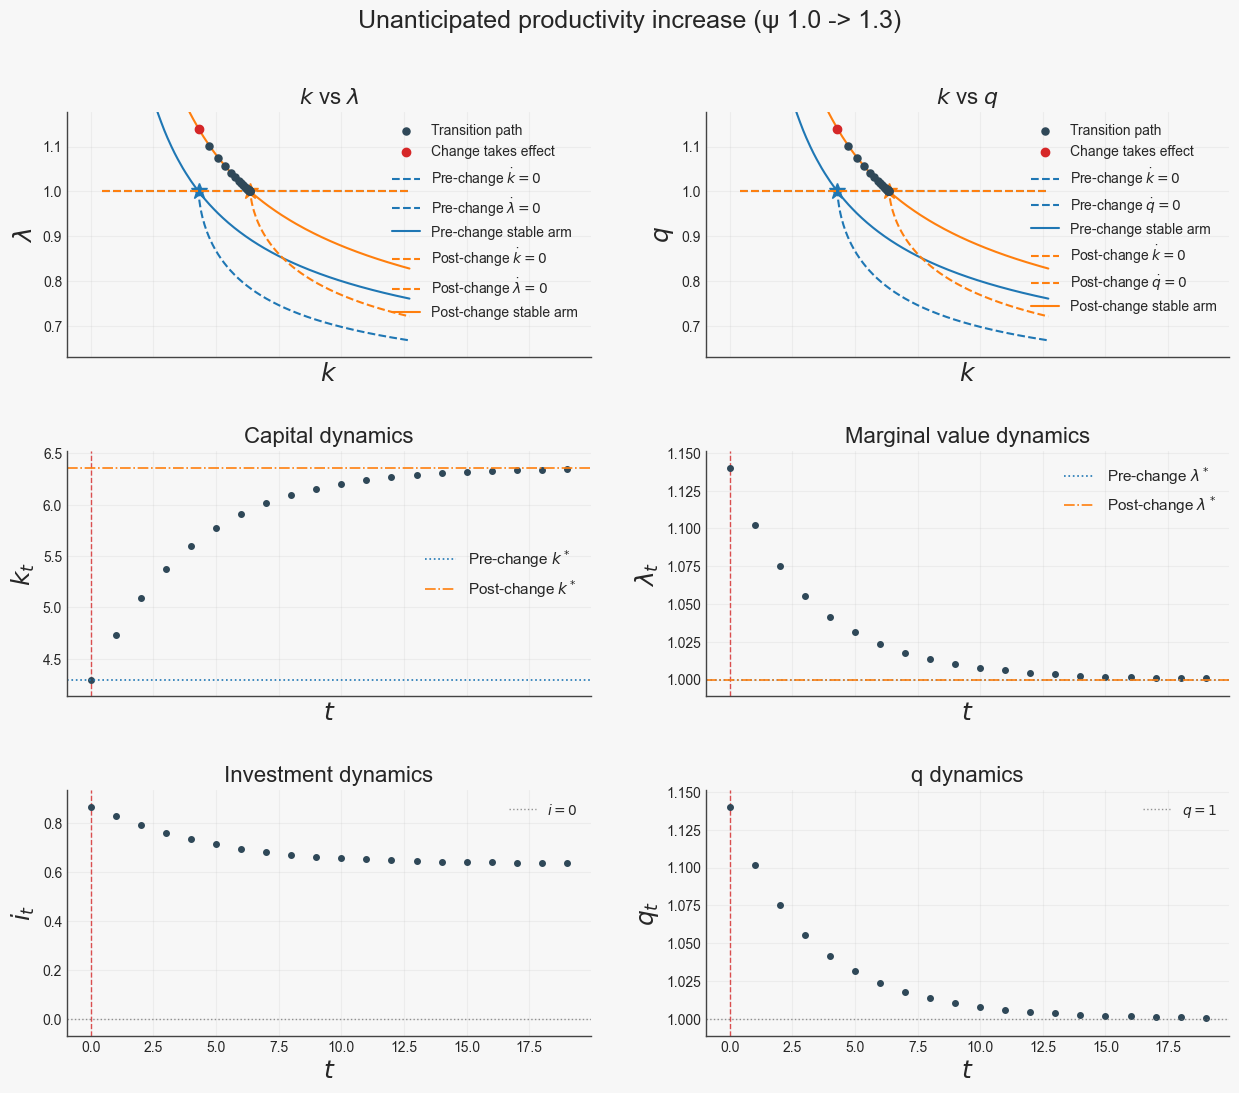

In [104]:

figname = 'ProductivityIncrease'
experiment_label = 'Unanticipated productivity increase (ψ 1.0 -> 1.3)'

# Total simulation time
T = 20
# Time the change occurs
t = 0
# Initial level of capital
k0 = Qmodel.kss

# Productivity in the "new" state
psi_new = 1.3

## Qmod class

# Copy the initial model, set the higher psi and re-solve
Q_high_psi = deepcopy(Qmodel)
Q_high_psi.psi = psi_new
Q_high_psi.solve()

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_psi,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, experiment_label=experiment_label)
fig = plt.gcf() # Get the figure in order to save it


## 2. An increase in productivity announced at t=0 but taking effect at t=5

    Desired error not necessarily achieved due to precision loss.


         Current function value: -78.057692
         Iterations: 20
         Function evaluations: 246
         Gradient evaluations: 41


    This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


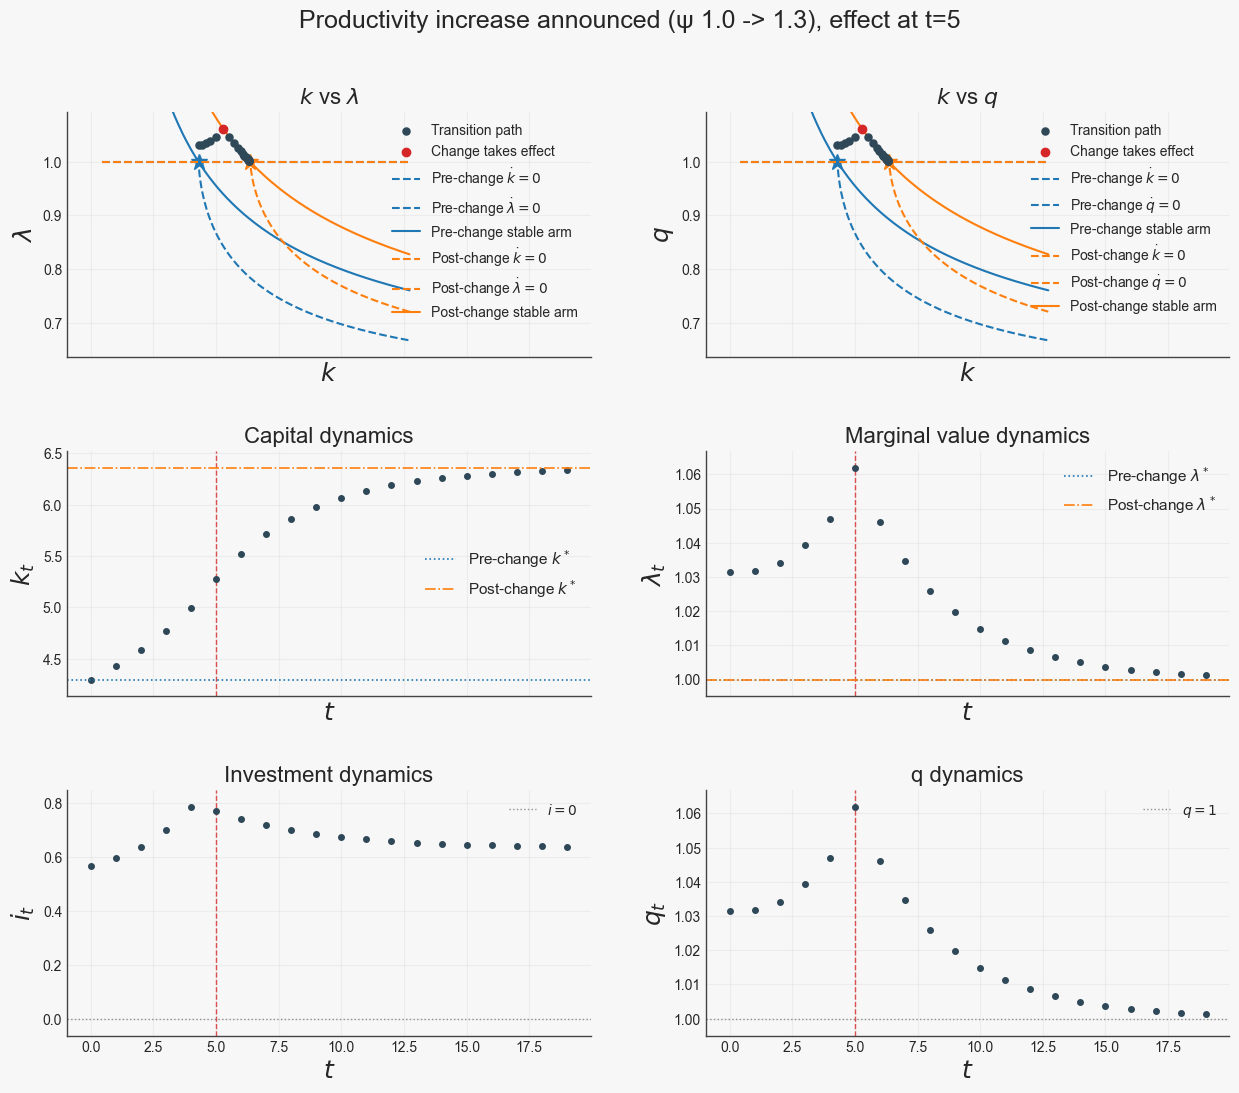

In [105]:

figname = 'ProductivityIncrease-ant'
experiment_label = 'Productivity increase announced (ψ 1.0 -> 1.3), effect at t=5'

# Repeat the calculation now assuming the change happens at t=5
t = 5

# Qmod class
sol = structural_change(mod1 = Qmodel, mod2 = Q_high_psi,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, experiment_label=experiment_label)


## 3. An unanticipated corporate tax-cut

    This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


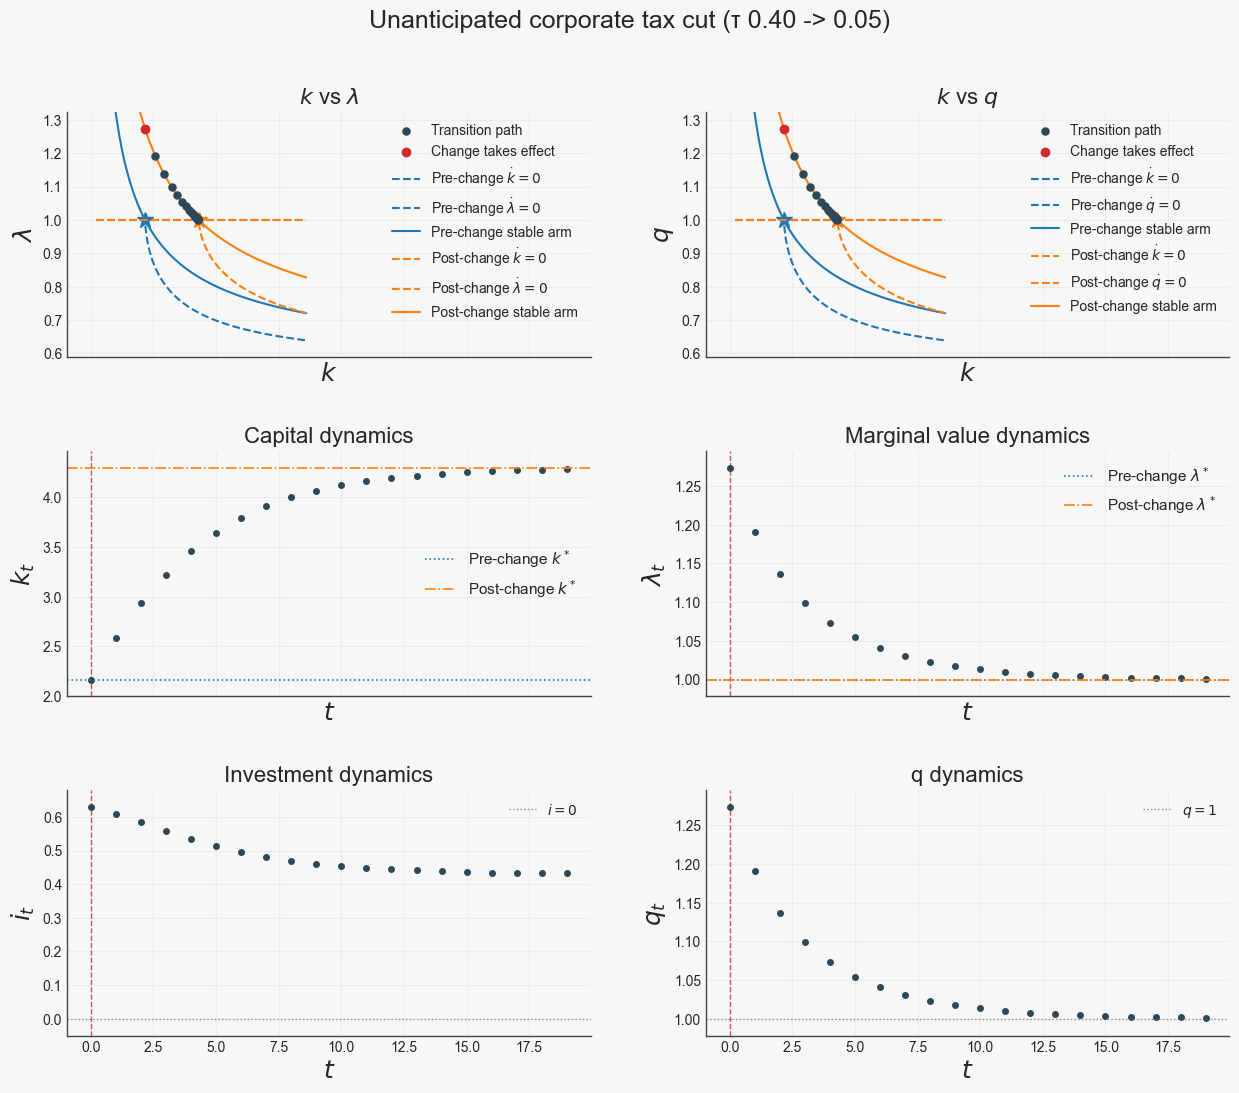

In [106]:

figname = 'CorporateTaxReduction'
experiment_label = 'Unanticipated corporate tax cut (τ 0.40 -> 0.05)'

# Set the taxes of the 'high-tax' scenario
tau_high = 0.4
# Set time of the change
t = 0

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

# Capital will start at it steady state in the
# high-tax scenario
k0 = Q_high_tau.kss

sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, experiment_label=experiment_label)


## 4. A corporate tax cut announced at t=0 but taking effect at t=5

    Desired error not necessarily achieved due to precision loss.


         Current function value: -51.110475
         Iterations: 13
         Function evaluations: 354
         Gradient evaluations: 57


    This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


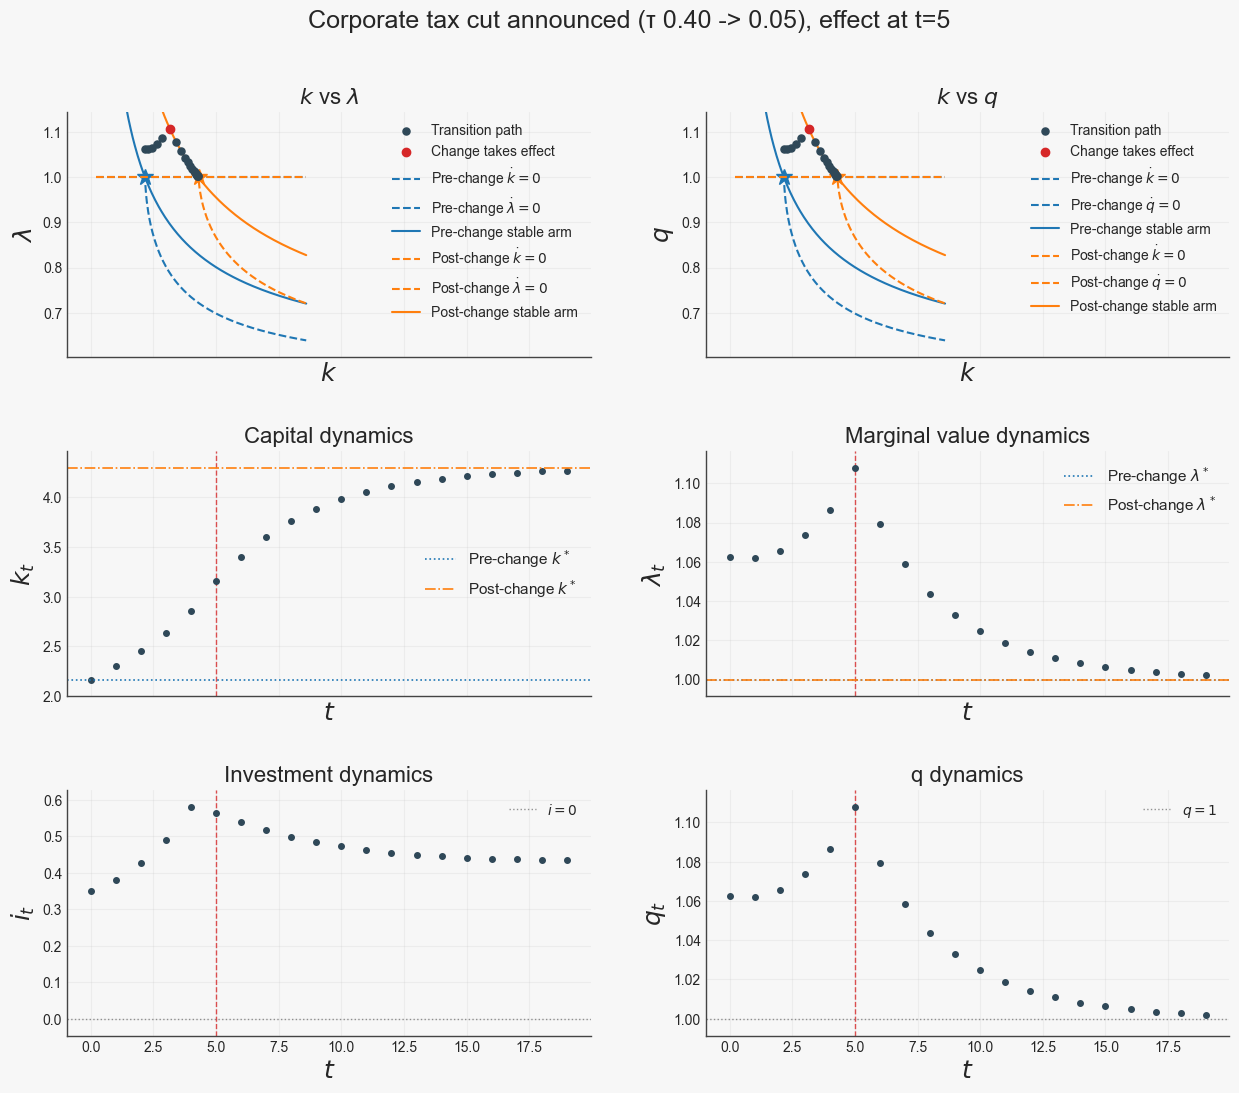

In [107]:

figname = 'CorporateTaxReduction-ant'
experiment_label = 'Corporate tax cut announced (τ 0.40 -> 0.05), effect at t=5'

# Modify the time of the change
t = 5

# Qmod class
sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, experiment_label=experiment_label)


## 5. An unanticipated ITC increase

    This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


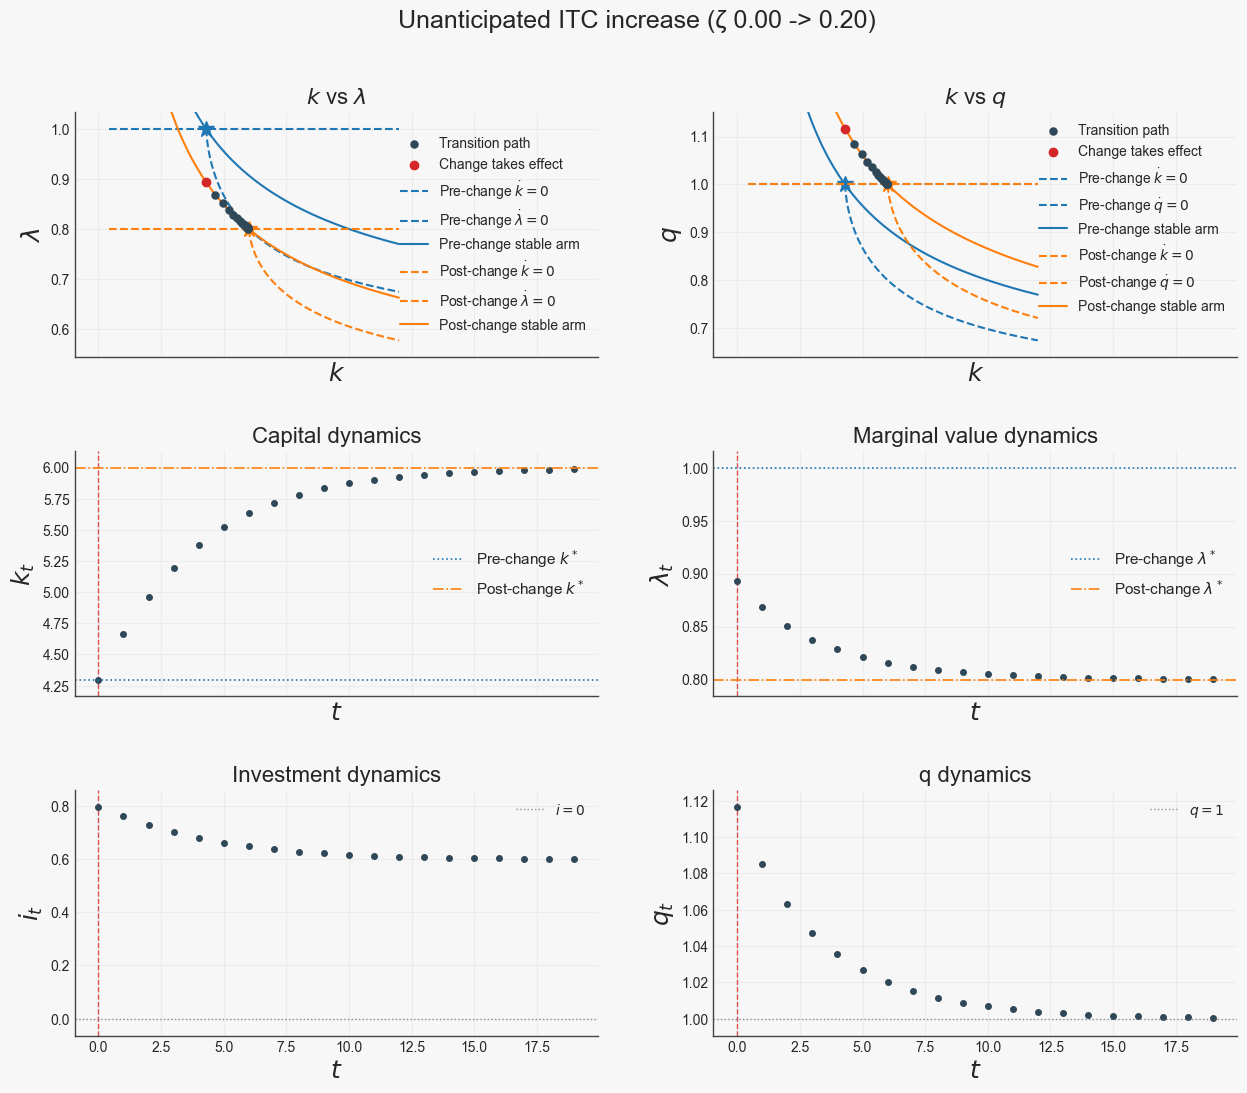

In [108]:

figname = 'ITCIncrease'
experiment_label = 'Unanticipated ITC increase (ζ 0.00 -> 0.20)'

# Set time of the change
t=0
# Set investment tax credit in the high case
itc_high = 0.2
# Set initial value of capital
k0 = Qmodel.kss

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_itc = deepcopy(Qmodel)
Q_high_itc.zeta = itc_high
Q_high_itc.solve()

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_itc,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, experiment_label=experiment_label)


## 6. An ITC increase announced at t=0 but taking effect at t=5

    Desired error not necessarily achieved due to precision loss.


         Current function value: -60.398780
         Iterations: 23
         Function evaluations: 276
         Gradient evaluations: 46


    This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


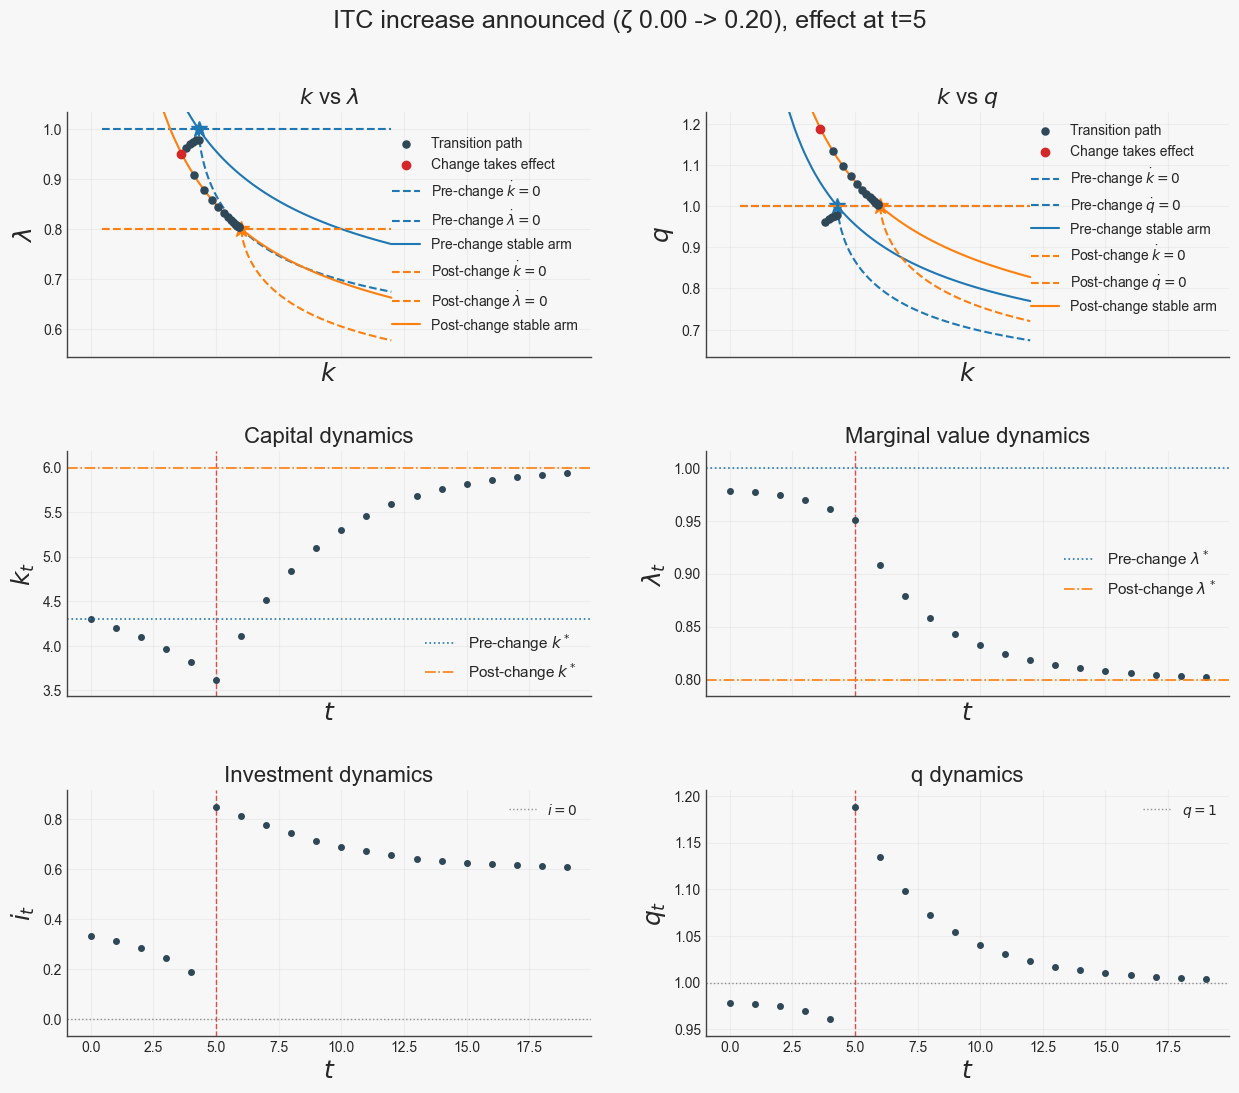

In [109]:

figname = 'ITCIncrease-ant'
experiment_label = 'ITC increase announced (ζ 0.00 -> 0.20), effect at t=5'

# Modify time of the change
t = 5

# Qmod class
sol = structural_change(mod1 = Qmodel, mod2 = Q_high_itc,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, experiment_label=experiment_label)
